# Data Exploration and algorithem/ data preprocessing choice

In [1]:
!pip install optuna -q

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import optuna
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Read File

In [3]:

X_test_ = pd.read_csv('../data/Xte.csv',sep=',',index_col=0)
X_train_ = pd.read_csv('../data/Xtr.csv',sep=',',index_col=0)

X_test_mat100 = pd.read_csv('../data/Xte_mat100.csv',sep=' ',header=None)
X_train_mat100 = pd.read_csv('../data/Xtr_mat100.csv',sep=' ',header=None)

y = pd.read_csv('../data/Ytr.csv',sep=',',index_col=0)

In [5]:
X_train_.head()

,seq
Id,
0,GAGGGGCTGGGGAGGGGGCTGGCCCAGAGGCACCAGACTCTGCAGA...
1,CGGCCTGGGGGCCACATGTGAGTGCTTACCTGTGTGGGGATGAGGG...
2,GACAACGCCGCTGTCAGCCGCCTTCGACTCACCTGGGAGGTGATGA...
3,GCCTCCCTTGGCACCACGGGAGACCAGTTTTGGAGGGGCGGGGCTG...
4,GCACTACTACACCCATTGCTGTAATAGTAAGTGCCGGTGCCTTCAC...


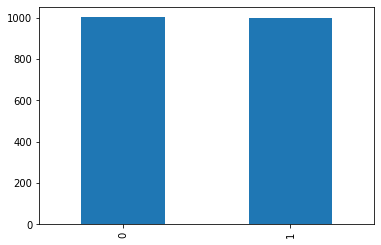

In [6]:
y['Bound'].value_counts().plot.bar()

In [7]:
X_train['Count'] = X_train.seq.apply(lambda x:len(x))
X_train['Count'].value_counts().plot.bar()

NameError: name 'X_train' is not defined

# Models To test whih is good representation

In [8]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


def test_data(X,y):
    results = {}
    X=scale(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    classifier = SVC(kernel = 'linear', C = 0.1, gamma = 0.01)
    classifier.fit(X_train, y_train)
    results['svm'] = classifier.score(X_test,y_test)

    clf = LogisticRegression(random_state=0,penalty='l2').fit(X, y)
    results['lr'] = clf.score(X_test,y_test)
    
    return results

# Explore representation methods
[methods](https://medium.com/analytics-vidhya/demystify-dna-sequencing-with-machine-learning-and-python-bdbaeb177f56)

- this results dectate the smaller resut we must get from our models 

In [9]:
# 1. TESTING THE DEFAULT DATA WE HAVE
test_data(X_train_mat100,y.values.flatten())

{'lr': 0.65, 'svm': 0.58}

In [8]:
# Ordinal encoding DNA sequence data
import re
def string_to_array(seq_string):
    seq_string = seq_string.lower()
    seq_string = re.sub('[^acgt]', 'n', seq_string)
    seq_string = np.array(list(seq_string))
    return seq_string

# create a label encoder with 'acgtn' alphabet
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t','z']))

def ordinal_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    float_encoded = integer_encoded.astype(float)
    float_encoded[float_encoded == 0] = 0.25 # A
    float_encoded[float_encoded == 1] = 0.50 # C
    float_encoded[float_encoded == 2] = 0.75 # G
    float_encoded[float_encoded == 3] = 1.00 # T
    float_encoded[float_encoded == 4] = 0.00 # anything else, lets say n
    return float_encoded

X_tr = X_train_.seq.values
X_list = []
for i in X_tr:
    X_list.append(ordinal_encoder(string_to_array(i)))
    
    
test_data(np.array(X_list),y.values.flatten())

{'lr': 0.6466666666666666, 'svm': 0.5783333333333334}

In [20]:
#DNA sequence as a “language”, known as k-mer counting
def getKmers(sequence, size=3):
    return [sequence[x:x+size] for x in range(len(sequence) - size + 1)]
# def get_n_grams(data1,n):
#     X_train = []
#     X_test = []

#     cv = CountVectorizer(ngram_range=(5,5))
#     for i in data1:
#         sentence = ' '.join(getKmers(i[0], size=n))
#         X_train.append(sentence)
        
#     X_cocat = X_train
#     X = cv.fit_transform(X_cocat).toarray()
#     return X

# X_preprocess = get_n_grams(X_train_.values,6)

# test_data(X_preprocess,y.values.flatten())

In [25]:
def base2int(c):
    return {'A':0,'C':1,'G':2,'T':3}.get(c,0)

def index(kmer):
    base_idx = np.array([base2int(base) for base in kmer])
    multiplier = 4** np.arange(len(kmer))
    kmer_idx = multiplier.dot(base_idx)
    
    return kmer_idx
    
    
def spectral_embedding(sequence):
    kmers = getKmers(sequence)
    kmer_idxs = [index(kmer) for kmer in kmers]
    one_hot_vector = np.zeros(4**kmer_idxs)
    
    for kmer_idx in kmer_idxs:
        one_hot_vector[kmer_idx] += 1
    return one_hot_vector

In [26]:
# spectral_embedding
spectral_embedding(X_train_.values[2][0])

TypeError: unsupported operand type(s) for ** or pow(): 'int' and 'list'

In [129]:
# Count Vectorizer 
def get_n_grams(data1):
    cv = CountVectorizer(analyzer='char',ngram_range=(5,5))
    X = cv.fit_transform(data1).toarray()
    return X

X_preprocess = get_n_grams(X_train.seq.values.flatten())

test_data(X_preprocess,y.values.flatten())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



{'lr': 0.9283333333333333, 'svm': 0.6016666666666667}

In [130]:
# Count Vectorizer 
def get_tf_idf_grams(data1):
    cv = TfidfVectorizer(analyzer='char',ngram_range=(5,5))
    X = cv.fit_transform(data1).toarray()
    return X

X_preprocess = get_n_grams(X_train.seq.values.flatten())

test_data(X_preprocess,y.values.flatten())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



{'lr': 0.9316666666666666, 'svm': 0.5933333333333334}

In [18]:
def LevenshteinDistance(str1,str2):
    '''
    Compute the edit distance between str1 and str2
    Param: @(str1): (str) string 1 for the comparison
    @(str2): (str) string 2 for the comparison
    Return (int) distance
    '''
    len_s1 = len(str1) +1
    len_s2 = len(str2) +1
    m = np.zeros((len_s1,len_s2))
    for i in range(len_s1):
        m[i,0] = i
    
    for j in range(len_s2):
        m[0,j] = j
    
    for i in range(1,len_s1):
        for j in range(1,len_s2):
            if str1[i-1]==str2[j-1]:
                m[i,j]= min(m[i-1,j]+1,m[i,j-1]+1,m[i-1,j-1])
            else:
                m[i,j] =min(m[i-1,j]+1,m[i,j-1]+1,m[i-1,j-1]+1)
    return m[-1,-1]
#DNA sequence as a “language”, known as k-mer counting
def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]
def get_n_grams(data1,n):
    X_train = []
    for i in data1:
        sentence = ' '.join(getKmers(i[0], size=n))
        X_train.append(sentence)
        
    return X_train

X_preprocess = get_n_grams(X_train_.values,6)

In [19]:
X_preprocess

['gagggg aggggc ggggct gggctg ggctgg gctggg ctgggg tgggga ggggag gggagg ggaggg gagggg aggggg gggggc ggggct gggctg ggctgg gctggc ctggcc tggccc ggccca gcccag cccaga ccagag cagagg agaggc gaggca aggcac ggcacc gcacca caccag accaga ccagac cagact agactc gactct actctg ctctgc tctgca ctgcag tgcaga gcagaa cagaac agaacc gaacca aaccac accacc ccaccc caccca acccag cccagg ccaggc caggca aggcat ggcatt gcattg cattgt attgtg ttgtgg tgtggg gtgggg tggggc ggggct gggctg ggctgc gctgcc ctgccc tgccct gccctg ccctgc cctgcc ctgcca tgccac gccacc ccacct cacctg acctgc cctgct ctgctg tgctgg gctggc ctggcc tggccg ggccgc gccgct ccgctc cgctcc gctcct ctcctg tcctgg cctggt ctggtg tggtgg ggtggc gtggca tggcag',
 'cggcct ggcctg gcctgg cctggg ctgggg tggggg gggggc ggggcc gggcca ggccac gccaca ccacat cacatg acatgt catgtg atgtga tgtgag gtgagt tgagtg gagtgc agtgct gtgctt tgctta gcttac cttacc ttacct tacctg acctgt cctgtg ctgtgt tgtgtg gtgtgg tgtggg gtgggg tgggga ggggat gggatg ggatga gatgag atgagg tgaggg gaggga agggag gggaga ggagag gagagg 

In [ ]:
for i in 